# Estadisticas De Casos de COVID-19 en México y sus entidades
    Autor: Eduardo Alán Hernández Villasana
    Estudiante de Licenciatura en Ciencias Computacionales en
    la Universidad Autonoma de Nuevo León - Facultad de Ciencias Fisico Matemáticas

In [1]:
import pandas as ps
import os
import datetime as dt
import matplotlib.pyplot as plt
import time

In [2]:
class Entidad:
    Nombre = ""
    HT = ""
    CPositivos = 0
    CNegativos = 0
    CSospechosos =0
    Fallecidos = 0
    MpM = 0.0

In [3]:
def agregarResultado (data_frame):
    RESULTADO = []
    for CL in data_frame["CLASIFICACION_FINAL"]:
        RESULTADO.append(obtenerResultado(CL))
    #print(RESULTADO)
    data_frame["RESULTADO"] = RESULTADO


In [4]:
def obtenerResultado (CLASIFICACION_FINAL):
    POSITIVO = [1,2,3]
    NEGATIVO = [7]
    SOSPECHOSO = 6

    if (CLASIFICACION_FINAL in POSITIVO):
        return 1
    elif (CLASIFICACION_FINAL in NEGATIVO):
        return 2
    else:
        return 3


In [5]:
# Función para obtener el dataframe desde un url, también calcula la fecha y obtiene el dataframe de el dia actual o el de ayer
def obtenerDataFrame (fecha = "hoy"):
    #url = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Datos%20Abiertos"
    url = "../../../COVIDSTATSMX/Datos Abiertos"
    x = dt.date.today()
    fecha = str(x)
    sufijo = "COVID19MEXICO.csv"
    # 200617COVID19MEXICO.csv
    año = str(x.year - 2000)
    if x.month >= 10:
        mes = str(x.month)
    else:
        mes = "0" + str(x.month)
    
    if x.day >= 10:
        dia = str(x.day)
    else:
        dia = "0" + str(x.day)

    prefijo = año + mes + dia
    try:
        covid_df = ps.read_csv(url + "/" + prefijo + sufijo, encoding ='latin1')
        print ("DataSet obtenido de: \n" + url + "/" + prefijo + sufijo)
    except:
        x = x - dt.timedelta(days = 1)
        fecha = str(x)
        año = str(x.year - 2000)
        if x.month >= 10:
            mes = str(x.month)
        else:
            mes = "0" + str(x.month)
        
        if x.day >= 10:
            dia = str(x.day)
        else:
            dia = "0" + str(x.day)

        prefijo = año + mes + dia
        try:
            covid_df = ps.read_csv(url + "/" + prefijo + sufijo, encoding ='latin1')
            print ("DataSet obtenido de: \n" + url + "/" + prefijo + sufijo)
        except:
            covid_df = None
            fecha = "0"
    #print (dt.datetime.now() - x) Para medir el tiempo que se tarda en leer el dataset
    return covid_df, fecha

In [6]:
# Guarda un dataframe dependiendo de el nombre, el path y especificando que tipo de extencion y formatp
def guardarDataFrame (path = "C:", nombre = "DATAFRAME", tipo = ".xls", dataFrame = None):
    if tipo == ".csv":
        dataFrame.to_csv(os.path.join(path, nombre))
    elif tipo == ".xls":
        dataFrame.to_excel(os.path.join(path, nombre))
    elif tipo == ".json":
        dataFrame.to_json(os.path.join(path, nombre))

In [7]:
# Imprime los datos acumulados
def imprimirAcumulados (casosA):
    # variable que guarda el indice de letalidad en porcentaje
    inice_L = casosA["Defunciones"] / casosA["Positivos"] * 100
    # Variable que guarda el indice de positividad nacional
    indice_P = casosA["Positivos"] / (casosA["Negativos"] + casosA["Positivos"]) * 100
    print ("  Total de casos estudiados: " + str(casosA["Total"])+ "\n\n" +
            "  Casos Positivos a SARS-CoV-2: " + str(casosA["Positivos"])+ "\n\n" +
            "  Casos No Positivos a SARS-CoV-2: " + str(casosA["Negativos"])+ "\n\n" +
            "  Casos Con Resultado Pendiente: " + str(casosA["Pendientes"]) + "\n\n" +
            "  Defunciones Positivas a SARS-CoV-2: " + str(casosA["Defunciones"]) + "\n\n" +
            "  Tasa de Letalidad: %.3f%s\n\n  Tasa de Positividad : %.3f%s\n" % (inice_L,"%",indice_P,"%"))

In [8]:
# Guarda en un diccionario los casos acumulados
def obtenerCasosAcumulados (covid_df):
    # Data Frame que almacenará la columna RESULTADO donde 1 es positivo, 2 es negativo, 3 es pendiente y FECHA_DEF, donde si la fecha es diferente a 9999-99-99 es una defuncion
    #casos = ps.concat([covid_df["RESULTADO"], covid_df["FECHA_DEF"]], axis = 1)
    
    casos = covid_df[["RESULTADO", "FECHA_DEF"]]
    # Contador de los casos positivos
    positivos = len(casos[casos["RESULTADO"] == 1]) 
    # Contador de los casos negativos
    negativos = len(casos[casos["RESULTADO"] == 2])
    # Contador de los casos pendientes
    pendientes = len(casos[casos["RESULTADO"] == 3])
    # Contador de defunciones por covid-19
    defunciones = len(casos[(casos["RESULTADO"] == 1) & (casos["FECHA_DEF"] != "9999-99-99")])
    #print (casos.head())
    """
    for i in range (len(casos)):
        if casos["RESULTADO"][i] == 1:
            positivos += 1
            if casos ["FECHA_DEF"][i] != "9999-99-99":
                defunciones +=1
        elif casos["RESULTADO"][i] == 2:
            negativos += 1
        elif casos["RESULTADO"][i] == 3:
            pendientes +=1
    """
    return {"Positivos": positivos, "Negativos":negativos, "Pendientes":pendientes, "Defunciones": defunciones, "Total": len(casos)}

In [9]:
def obtenerListaFechas (hoy_s):
    i = dt.date(2020,1,1)
    hoy_l = hoy_s.split('-')
    hoy = dt.date(int(hoy_l[0]),int(hoy_l[1]),int(hoy_l[2]))
    p_fecha = str(i.year)+"-"+"0"+str(i.month)+"-"+"0"+str(i.day)
    fechas = [p_fecha]
    while i != hoy:
        i += dt.timedelta(days = 1)

        if (i.month < 10):
            month = "0"+str(i.month)
        else:
            month = str(i.month)
        
        if (i.day < 10):
            day = "0"+str(i.day)
        else:
            day = str(i.day)
        
        p_fecha = str(i.year)+"-"+month+"-"+day
        fechas.append(p_fecha)
    return fechas


In [10]:
# Filtra los datos y obtiene un diccionario con los casos registradps por dia
# Esta añadida la opcion de especificar el estado y la lista de municipios
def obtenerCasosPorDia (covid_df, estado = 0, municipios = []):
    # Lista que guarda las fechas de FECHA
    # Diccionario que guarda la posicion de las fechas
    pos_fechas = {}
    # Diccionario que se convertirá en Data Frame
    casosPorDia = {}
    # Se crean las listas que almacenarán los datos
    casosPorDia ["FECHA"] = []
    casosPorDia ["CASOS_POSITIVOS"] = []
    casosPorDia ["CASOS_NEGATIVOS"] = []
    casosPorDia ["CASOS_SOSPECHOSOS"] = []
    casosPorDia ["DEFUNCIONES"] = []
    total_Casos = len(covid_df)
    # Se crea la lista de las fechas
    
    # Se ordenan las fechas, debido al formato (dd/mm/aaaa) se tiene que invertir a (mm/dd/aaaa) para ordenarlo y después se devuelven a 
    # su posicion original
    #fechas = invertirLista(fechas)
    #fechas = invertirLista(fechas)
    casosPorDia ["FECHA"] = fechas
    # Se filtran los datos y se cuentan los casos positivos, negativos, sospechosos, y defunciones confirmadas por cada fecha
    # Para los casos positivos, negativos y sospechosos la columna "FECHA" representa su fecha de inicio de sintomas, 
    # mientras que para las defunciones, la columna "FECHA" representa la fecha de defunción.
    # No se debe olvidar que aqui solamente se muestran numeros frios, pero cada una de las defunciones representa una vida perdida.
    for fecha in casosPorDia["FECHA"]:
        casos = covid_df[["FECHA_SINTOMAS", "RESULTADO","FECHA_DEF"]][((covid_df["ENTIDAD_RES"] == estado) |( estado == 0)) 
        & ((covid_df["MUNICIPIO_RES"].isin (municipios)) | (len(municipios) == 0))]
        casos_S = casos[casos["FECHA_SINTOMAS"] == fecha]


        casos_P = casos_S[casos_S["RESULTADO"] == 1]

        casos_N = casos_S[casos_S["RESULTADO"] == 2]

        casos_S = casos_S[casos_S["RESULTADO"] == 3]

        Def = casos[(casos["FECHA_DEF"] == fecha) 
        & (casos["RESULTADO"] == 1)]

        casosPorDia ["CASOS_POSITIVOS"].append(len(casos_P))
        casosPorDia ["CASOS_NEGATIVOS"].append(len(casos_N))
        casosPorDia ["CASOS_SOSPECHOSOS"].append(len(casos_S))
        casosPorDia ["DEFUNCIONES"].append(len(Def))
    return casosPorDia

In [11]:
def imprimirGrafica (nombre, casosPorDia_df,fecha):
    %matplotlib inline
    plt.figure(figsize = (20,10))
    plt.plot(casosPorDia_df["FECHA"],casosPorDia_df["CASOS_POSITIVOS"],"r")
    plt.plot(casosPorDia_df["FECHA"],casosPorDia_df["DEFUNCIONES"],"b")
    plt.plot(casosPorDia_df["FECHA"],casosPorDia_df["CASOS_SOSPECHOSOS"],"g")
    plt.title("GRAFICA " + nombre +" "+ fecha + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
    plt.savefig("../Graficas/" + fecha + "/"+ nombre+" " +fecha+ ".png")

In [12]:
covid_df, fecha_actualizacion = obtenerDataFrame()
fechas = obtenerListaFechas(fecha_actualizacion)
agregarResultado(covid_df)
os.makedirs("../Graficas/"+fecha_actualizacion, exist_ok=True)
os.makedirs("../Casos_Por_Dia/"+fecha_actualizacion, exist_ok=True)
Casos_Por_Dia = "../Casos_Por_Dia/"+fecha_actualizacion

DataSet obtenido de: 
../../../COVIDSTATSMX/Datos Abiertos/201125COVID19MEXICO.csv


In [13]:
agregarResultado(covid_df)

# Panorama Nacional

In [14]:
casosAcumulados = obtenerCasosAcumulados(covid_df)
imprimirAcumulados (casosAcumulados)

  Total de casos estudiados: 2771888

  Casos Positivos a SARS-CoV-2: 1070487

  Casos No Positivos a SARS-CoV-2: 1293654

  Casos Con Resultado Pendiente: 407747

  Defunciones Positivas a SARS-CoV-2: 103597

  Tasa de Letalidad: 9.678%

  Tasa de Positividad : 45.280%



In [15]:
nacional = Entidad()

In [16]:
# {"Positivos": positivos, "Negativos":negativos, "Pendientes":pendientes, "Defunciones": defunciones, "Total": len(casos)}
nacional.CPositivos = casosAcumulados["Positivos"]
nacional.CNegativos = casosAcumulados["Negativos"]
nacional.CSospechosos = casosAcumulados["Pendientes"]
nacional.Fallecidos = casosAcumulados["Defunciones"]
nacional.MpM = nacional.Fallecidos/127091642*1000000
nacional.HT = "#México"
nacional.Nombre = "NACIONAL"

### Obtención de datos por dia en el país.

In [17]:
casosPorDia_dict = obtenerCasosPorDia(covid_df)
casosPorDia_df = ps.DataFrame(casosPorDia_dict)
guardarDataFrame (path = Casos_Por_Dia,
nombre = fecha_actualizacion + "-NACIONAL.xls",
tipo = ".xls",
dataFrame = casosPorDia_df)

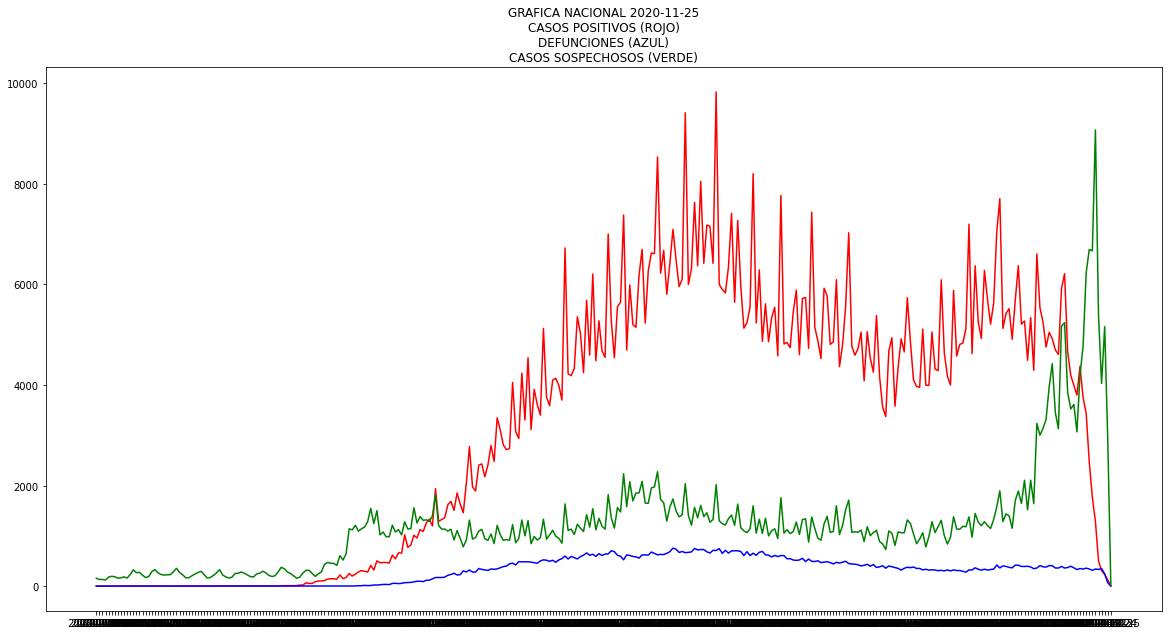

In [18]:
imprimirGrafica ("NACIONAL", casosPorDia_df, fecha_actualizacion)

# Obtención de información por Estado

In [19]:
poblacion = ps.read_csv("../Poblacion/Poblacion.csv")

In [20]:
estados = {"ESTADO":[],"HASHTAG":[],"CASOS_POSITIVOS":[],"CASOS_NEGATIVOS":[],"DEFUNCIONES":[],"SOSPECHOSOS":[],"TASA_POSITIVIDAD":[],"TASA_MORTALIDAD":[],"MUERTES_POR_MILLON":[],"HABITANTES":[]}
estados_info = []

ht = ["#Aguascalientes","#BajaCalifornia","#BajaCaliforniaSur","#Campeche","#Chiapas","#Chihuahua","#CDMX","#Coahuila","#Colima","#Durango","#Edoméx","#Guanajuato","#Guerrero","#Hidalgo","#Jalisco","#Michoacán","#Morelos","#Nayarit","#NuevoLeón","#Oaxaca","#Puebla","#Querétaro","#QuintanaRoo","#SanLuisPotosi","#Sinaloa","#Sonora","#Tabasco","#Tamaulipas","#Tlaxcala","#Veracruz","#Yucatán","#Zacatecas"]
i = 0
for estado_id in poblacion["CLAVE"]:
    # Se obtiene el nombre del ESTADO
    ESTADO = poblacion[poblacion["CLAVE"] == estado_id]["ESTADO"].tolist()[0]

    # Se obtiene el numero de CASOS POSITIVOS por estado
    CASOS_POSITIVOS = len (covid_df[(covid_df["ENTIDAD_RES"] == estado_id)
    & (covid_df["RESULTADO"] == 1)])

    # Se obtiene el numero de CASOS NEGATIVOS por estado
    CASOS_NEGATIVOS = len (covid_df[(covid_df["ENTIDAD_RES"] == estado_id)
    & (covid_df["RESULTADO"] == 2)])

    # Se obtiene el numero de DEFUNCIONES por estado
    DEFUNCIONES = len (covid_df[(covid_df["ENTIDAD_RES"] == estado_id)
    & (covid_df["RESULTADO"] == 1)
    & (covid_df["FECHA_DEF"] != "9999-99-99")])

    # Se obtiene el numero de SOSPECHOSOS por estado
    SOSPECHOSOS = len (covid_df[(covid_df["ENTIDAD_RES"] == estado_id)
    & (covid_df["RESULTADO"] == 3)])

    # Se obtiene la TASA de POSITIVIDAD por estado
    TASA_POSITIVIDAD = CASOS_POSITIVOS/(CASOS_NEGATIVOS + CASOS_POSITIVOS)

    # Se obtiene la TASA de MORTALIDAD por estado
    TASA_MORTALIDAD = DEFUNCIONES/CASOS_POSITIVOS

    # Se obtiene las MUERTES POR MILLON de habitantes por estado
    totalPoblacion = int(poblacion[poblacion["CLAVE"] == estado_id]["POBLACION"].tolist()[0])
    MUERTES_POR_MILLON = DEFUNCIONES / totalPoblacion * 1000000

    # Se incluyen los datos en el diccionario estados
    estados["ESTADO"].append(ESTADO)
    estados["CASOS_POSITIVOS"].append(CASOS_POSITIVOS) 
    estados["CASOS_NEGATIVOS"].append(CASOS_NEGATIVOS)
    estados["DEFUNCIONES"].append(DEFUNCIONES)
    estados["SOSPECHOSOS"].append(SOSPECHOSOS)
    estados["TASA_POSITIVIDAD"].append(TASA_POSITIVIDAD)
    estados["TASA_MORTALIDAD"].append(TASA_MORTALIDAD)
    estados["MUERTES_POR_MILLON"].append(MUERTES_POR_MILLON)
    estados["HABITANTES"].append(totalPoblacion)
    estados["HASHTAG"].append(ht[i])

    estados_info.append(Entidad())
    estados_info[i].CPositivos = CASOS_POSITIVOS
    estados_info[i].CNegativos = CASOS_NEGATIVOS
    estados_info[i].Fallecidos = DEFUNCIONES
    estados_info[i].CSospechosos = SOSPECHOSOS
    estados_info[i].HT = ht[i]
    estados_info[i].Nombre = ESTADO
    estados_info[i].MpM = MUERTES_POR_MILLON

    i+=1
estados_df = ps.DataFrame(estados)

In [21]:
estados_df

,ESTADO,HASHTAG,CASOS_POSITIVOS,CASOS_NEGATIVOS,DEFUNCIONES,SOSPECHOSOS,TASA_POSITIVIDAD,TASA_MORTALIDAD,MUERTES_POR_MILLON,HABITANTES
0,AGUASCALIENTES,#Aguascalientes,12779,23362,1049,8285,0.353587,0.082088,766.081504,1369306
1,BAJA CALIFORNIA,#BajaCalifornia,25883,17782,4234,26856,0.592763,0.163582,1135.356542,3729225
2,BAJA CALIFORNIA SUR,#BajaCaliforniaSur,14104,24483,660,2778,0.365512,0.046795,750.998487,878830
3,CAMPECHE,#Campeche,6733,9731,905,3901,0.408953,0.134413,928.322240,974877
4,CHIAPAS,#Chiapas,7707,6974,1172,28080,0.524964,0.152070,210.464012,5568648
5,CHIHUAHUA,#Chihuahua,28797,17416,3344,8543,0.623136,0.116123,861.247691,3882739
6,CIUDAD DE MÉXICO,#CDMX,193819,340065,13235,91950,0.363036,0.068285,1514.490244,8738914
7,COAHUILA DE ZARAGOZA,#Coahuila,40333,49032,3176,12298,0.451329,0.078744,1014.767163,3129782
8,COLIMA,#Colima,7091,5647,744,2102,0.556681,0.104922,950.396701,782831
9,DURANGO,#Durango,19764,23019,1126,4781,0.461959,0.056972,609.456755,1847547


In [22]:
sum(estados_df["HABITANTES"])

127091642

# Obtención de gráficas de casos por estado

In [23]:
estados_dic = {}
for estado_id in poblacion["CLAVE"]:
    ESTADO = poblacion[poblacion["CLAVE"] == estado_id]["ESTADO"].tolist()[0]
    estados_dic[ESTADO] =ps.DataFrame(obtenerCasosPorDia(covid_df, estado = estado_id))

    guardarDataFrame (path = Casos_Por_Dia,
    nombre = fecha_actualizacion + "-" +ESTADO+ ".xls",
    tipo = ".xls",
    dataFrame = estados_dic[ESTADO])
    print(ESTADO + " LISTO")

AGUASCALIENTES LISTO
BAJA CALIFORNIA LISTO
BAJA CALIFORNIA SUR LISTO
CAMPECHE LISTO
CHIAPAS LISTO
CHIHUAHUA LISTO
CIUDAD DE MÉXICO LISTO
COAHUILA DE ZARAGOZA LISTO
COLIMA LISTO
DURANGO LISTO
ESTADO DE MÉXICO LISTO
GUANAJUATO LISTO
GUERRERO LISTO
HIDALGO LISTO
JALISCO LISTO
MICHOACÁN DE OCAMPO LISTO
MORELOS LISTO
NAYARIT LISTO
NUEVO LEÓN LISTO
OAXACA LISTO
PUEBLA LISTO
QUERÉTARO LISTO
QUINTANA ROO LISTO
SAN LUIS POTOSÍ LISTO
SINALOA LISTO
SONORA LISTO
TABASCO LISTO
TAMAULIPAS LISTO
TLAXCALA LISTO
VERACRUZ DE IGNACIO DE LA LLAVE LISTO
YUCATÁN LISTO
ZACATECAS LISTO


Gráficas Guardadas


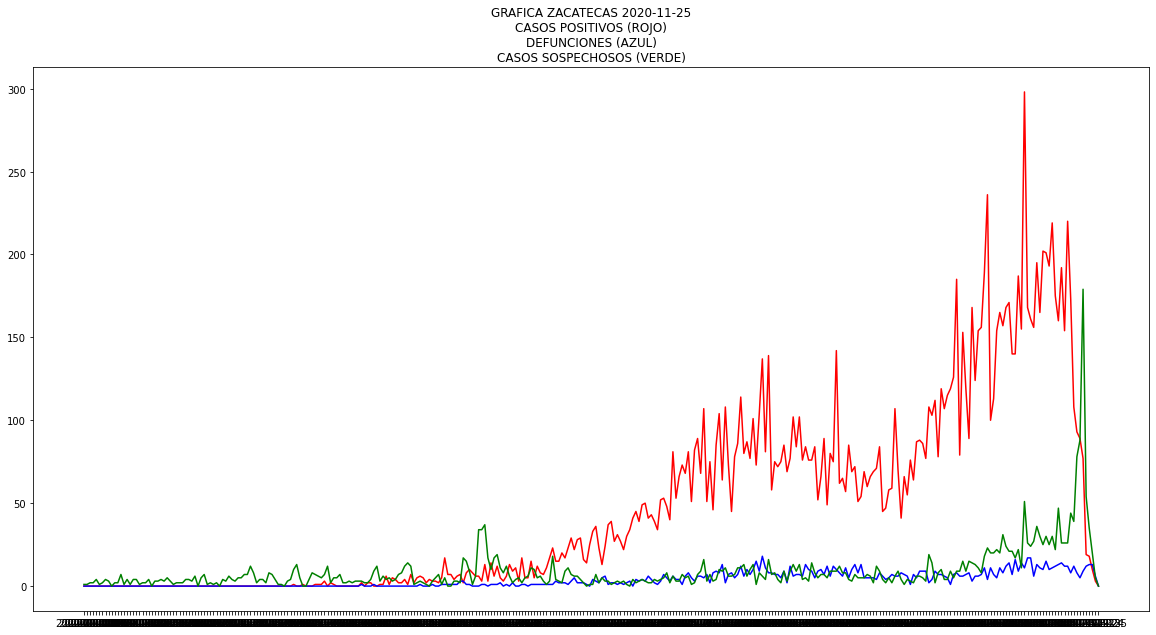

In [24]:
for estado in poblacion["ESTADO"]:
    imprimirGrafica (estado, estados_dic[estado], fecha_actualizacion)
print ("Gráficas Guardadas")


## Publicación de Tweeter

In [25]:
import sys
sys.path.insert(0,'../../../TweetCOVIDSTATSMX')
from My_Tweet import My_Tweet

In [26]:
fecha = fecha_actualizacion.split("-")
dia = fecha[2]
mes = fecha[1]
año = fecha[0]

In [27]:
for est in estados_info:
    time.sleep(30)
    info = "#COVID19 en "+est.HT+" #México al "+dia + "/" + mes +"/"+ año + "\nCasos Positivos: "+str(est.CPositivos)+"\nCasos Sospechosos: "+str(est.CSospechosos)+"\nCasos Negativos: "+str(est.CNegativos)+"\nFallecidos: "+str(est.Fallecidos)
    imagenpath = fecha_actualizacion + "/"+ est.Nombre +" " +fecha_actualizacion+ ".png"
    My_Tweet.post(info,imagenpath)

In [28]:
"""Covid-19 en #Mexico al 16/10/2020
Casos Positivos: 841661
Casos Sospechosos: 313678
Casos Negativos: 1004800
Fallecidos: 85708
Muertes por millón: 674.37
#COVID19 """
fecha = fecha_actualizacion.split("-")
dia = fecha[2]
mes = fecha[1]
año = fecha[0]
info = "#COVID19 en "+nacional.HT+" al "+dia + "/" + mes +"/"+ año + "\nCasos Positivos: "+str(nacional.CPositivos)+"\nCasos Sospechosos: "+str(nacional.CSospechosos)+"\nCasos Negativos: "+str(nacional.CNegativos)+"\nFallecidos: "+str(nacional.Fallecidos)
imagenpath = fecha_actualizacion + "/"+ nacional.Nombre +" " +fecha_actualizacion+ ".png"

In [29]:
My_Tweet.post(info,imagenpath)

# Proporción COVID Casos Especificoa


In [30]:
a = covid_df[(covid_df["RESULTADO"] == 1)
&(covid_df["EDAD"] >= 60)
&(covid_df["EDAD"] <= 70)
& (covid_df["SEXO"] == 2)
&(covid_df["EPOC"] == 2)
&(covid_df["ASMA"] == 2)
&(covid_df["INMUSUPR"] == 2)
&(covid_df["HIPERTENSION"] == 1)
&(covid_df["CARDIOVASCULAR"] == 2)
&(covid_df["OBESIDAD"] == 1)
&(covid_df["OTRA_COM"] == 2)
&(covid_df["RENAL_CRONICA"] == 2)
&(covid_df["TABAQUISMO"] == 2)]

b = len(a)

In [31]:
b

3965

In [32]:
con = a[(a["INTUBADO"] == 1)]
len(con)

516

In [33]:
c = a[a["FECHA_DEF"] != "9999-99-99"]
b_m = len (c)
b_m

1381

In [34]:
print("Tasa Mortalidad H = " + str(b_m/b*100) + "%")

Tasa Mortalidad H = 34.8297604035309%


In [35]:
dias = []
w = c["FECHA_SINTOMAS"].tolist()
q = c["FECHA_DEF"].tolist()
for i in range(len(w)):
    s = w[i]
    si = s.split("-")
    sint = dt.date(int(si[0]),int(si[1]),int(si[2]))


    d = q[i]
    de = d.split("-")
    defun = dt.date(int(de[0]),int(de[1]),int(de[2]))

    dias.append((defun-sint).days)

(array([17., 36., 40., 49., 76., 67., 92., 92., 62., 82., 84., 78., 58.,
        54., 55., 59., 42., 35., 40., 42., 22., 29., 15., 27., 18.,  9.,
        11., 13., 12.,  8.,  7.,  6.,  4.,  3.,  3.,  5.,  4.,  2.,  0.,
         5.,  0.,  3.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  1.01041667,  2.02083333,  3.03125   ,  4.04166667,
         5.05208333,  6.0625    ,  7.07291667,  8.08333333,  9.09375   ,
        10.10416667, 11.11458333, 12.125     , 13.13541667, 14.14583333,
        15.15625   , 16.16666667, 17.17708333, 18.1875    , 19.19791667,
        20.20833333, 21.21875   , 22.22916667, 23.23958333, 24.25      ,
        25.26041667, 26.27083333, 27.28125   , 28.29166667, 29.30208333,
        30.3125 

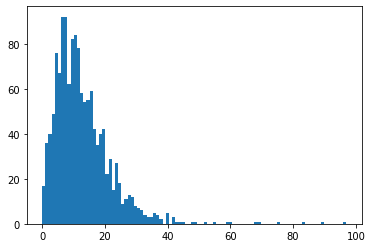

In [36]:
plt.hist(dias, bins = 96)

In [37]:
import numpy as np
np.mean(dias)

13.368573497465604

In [38]:
np.std(dias)

9.380499442838655

In [39]:
a = covid_df[(covid_df["RESULTADO"] == 1)
&(covid_df["EDAD"] >= 50)
&(covid_df["EDAD"] <= 60)
& (covid_df["SEXO"] == 1)
&(covid_df["EPOC"] == 2)
&(covid_df["ASMA"] == 2)
&(covid_df["INMUSUPR"] == 2)
&(covid_df["HIPERTENSION"] == 2)
&(covid_df["CARDIOVASCULAR"] == 2)
&(covid_df["OBESIDAD"] == 1)
&(covid_df["OTRA_COM"] == 2)
&(covid_df["RENAL_CRONICA"] == 2)
&(covid_df["TABAQUISMO"] == 2)]

b = len(a)
c = a[a["FECHA_DEF"] != "9999-99-99"]
b_m = len (c)

In [40]:
b

9606

In [41]:
con = a[(a["INTUBADO"] == 1)]
len(con)

407

In [42]:
print("Tasa Mortalidad M = " + str(b_m/b*100) + "%")

Tasa Mortalidad M = 9.98334374349365%


In [43]:
dias = []
w = c["FECHA_SINTOMAS"].tolist()
q = c["FECHA_DEF"].tolist()
for i in range(len(w)):
    s = w[i]
    si = s.split("-")
    sint = dt.date(int(si[0]),int(si[1]),int(si[2]))


    d = q[i]
    de = d.split("-")
    defun = dt.date(int(de[0]),int(de[1]),int(de[2]))

    dias.append((defun-sint).days)

In [44]:
len(dias)

959

(array([  9.,  42.,  35., 101., 102.,  63., 104.,  93.,  55.,  78.,  77.,
         22.,  40.,  43.,   7.,  16.,  18.,   8.,  10.,   8.,   0.,   7.,
          3.,   4.,   4.,   2.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.        ,   1.66666667,   3.33333333,   5.        ,
          6.66666667,   8.33333333,  10.        ,  11.66666667,
         13.33333333,  15.        ,  16.66666667,  18.33333333,
         20.        ,  21.66666667,  23.33333333,  25.        ,
         26.66666667,  28.33333333,  30.        ,  31.66666667,
         33.33333333,  35.    

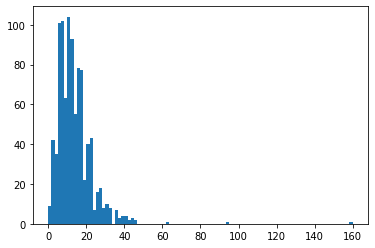

In [45]:
plt.hist(dias, bins = 96)

In [46]:
import numpy as np
np.mean(dias)

13.655891553701773

In [47]:
np.std(dias)

9.767284041757398

In [48]:
a = ["1","2","3"]
b = sorted(a, reverse=True)
print (len(a))

3
